In [20]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy

plt.set_cmap('gray')
scale = 2
plt.rcParams['figure.figsize'] = (2 * scale, scale)

<Figure size 400x200 with 0 Axes>

(1320, 1406)


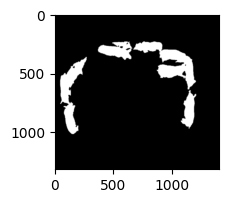

In [21]:
im = cv2.imread('pic/after_morpho.png', flags = cv2.IMREAD_GRAYSCALE)
print(im.shape)
plt.imshow(im)

# Zhang2005
### fill holes

In [22]:
contours, hierarchy = cv2.findContours(im, mode = cv2.RETR_TREE, method = cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

16


0-th Contour area is 25351.0
Center at (1142.742331006009, 815.9270508724178)


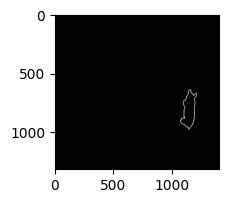

3-th Contour area is 61655.5
Center at (132.2667510062633, 675.1580853830287)


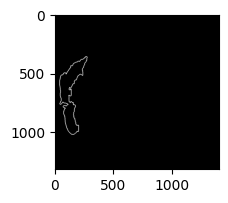

7-th Contour area is 31779.5
Center at (529.7777602962077, 300.00640349911106)


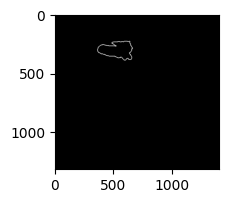

13-th Contour area is 83001.0
Center at (984.7595792018569, 402.19946346027956)


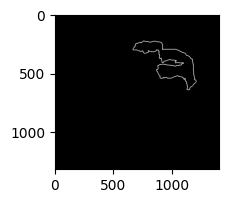

In [34]:
bkg = np.zeros_like(im)
# fig = plt.figure(figsize = (10, 7))
# fig.tight_layout()
# plt.subplots_adjust(wspace = 0, hspace = 0)
# r, c = 5, 2

for i, cnt in enumerate(contours):
    area = cv2.contourArea(contour = cnt, oriented = False)
    if area < 8000:
        continue
    print(f'{i}-th Contour area is {area}')
    M = cv2.moments(cnt)
    cx = M['m10'] / M['m00']
    cy = M['m01'] / M['m00']
    print(f'Center at {(cx, cy)}')
    # print(np.squeeze(cnt))
    tmp_bkg = copy.deepcopy(bkg) # cv2.drawContour, destination image
    cnt_im = cv2.drawContours(image = tmp_bkg, contours = contours, contourIdx = i, color = 127, thickness = 3)
    plt.imshow(cnt_im)
    # plt.axis('off')
    plt.show()

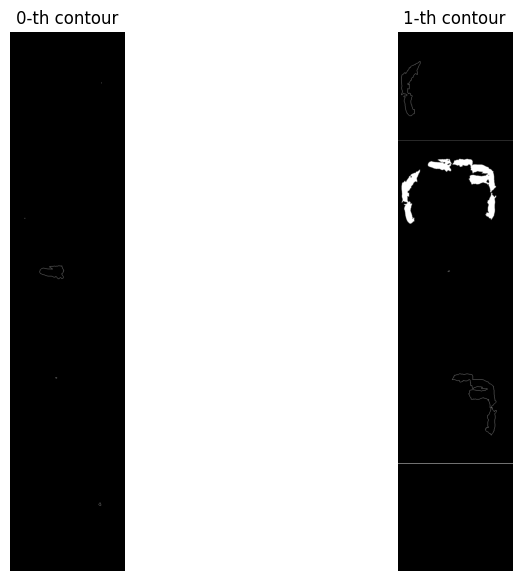

In [10]:
bkg = np.zeros_like(im)
fig = plt.figure(figsize = (10, 7))
fig.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0)
r, c = 5, 2

for i, cnt in enumerate(contours):
    tmp_bkg = copy.deepcopy(bkg) # cv2.drawContour, destination image
    cnt_im = cv2.drawContours(image = tmp_bkg, contours = contours, contourIdx = i, color = 127, thickness = 1)
    fig.add_subplot(r, c, i + 1)
    if i == 3:
        plt.imshow(im)
    else:
        plt.imshow(cnt_im)
    plt.axis('off')
    plt.title(f"{i}-th contour")
plt.show()